In [ ]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib as plt
from dataclasses import dataclass
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEMPERATURES_CSV = '/content/drive/MyDrive/daily-min-temperatures.csv'
with open(TEMPERATURES_CSV, 'r') as f:
  print(f.readline())
  print(f.readline())
  print(f.readline())

"Date","Temp"

"1981-01-01",20.7

"1981-01-02",17.9



In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Vẽ biểu đồ các bước thời gian (một loạt các điểm trong thời gian) với các giá trị (một loạt các giá trị trên các bước thời gian).
  
  Tham số
  ---------
  timesteps : mảng của các bước thời gian
  values : mảng của các giá trị theo theo thời gian
  format : kiểu của biểu đồ, mặc định là "."
  start : nơi bắt đầu biểu đồ (đặt một giá trị sẽ lập chỉ mục từ start của timesteps & values)
  end : nơi kết thúc biểu đồ (đặt một giá trị sẽ lập chỉ mục từ end của timesteps & values)
  label : nhãn để hiển thị trên biểu đồ giá trị
  """
  # Vẽ biểu đồ các chuỗi
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Temperatures")
  if label:
    plt.legend(fontsize=14) # làm cho nhãn lớn hơn
  plt.grid(True)

In [ ]:
def compute_metrics(true_series, forecast):
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
  return mse, mae

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

# Phân tích dữ liệu thô

In [ ]:
def parse_data_from_file(filename):
  times = []
  temperatures = []
  with open(filename) as f:
    reader = csv.reader(f, delimiter=',')
    next(reader,None)
    for line in reader:
      times.append(datetime.strptime(line[0], "%Y-%m-%d"))
      temperatures.append(float(line[1]))
  return times, temperatures

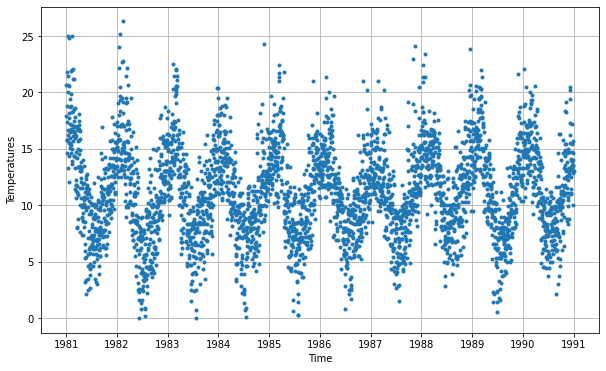

In [ ]:
@dataclass
class G:
  TEMPERATURES_CSV = '/content/drive/MyDrive/daily-min-temperatures.csv'
  times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
  TIME = np.array(times)
  SERIES = np.array(temperatures)
  SPLIT_TIME = 2500
  WINDOW_SIZE = 64
  HORIZON = 1
  BATCH_SIZE = 32
  SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10,6))
plot_time_series(G.TIME, G.SERIES)
plt.show()

#Processing the data

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
  time_train = time[:time_step]
  time_val = time[time_step:]
  series_train = series[:time_step]
  series_val = series[time_step:]
  return time_train, series_train, time_val, series_val
time_train, series_train, time_val, series_val = train_val_split(G.TIME, G.SERIES)

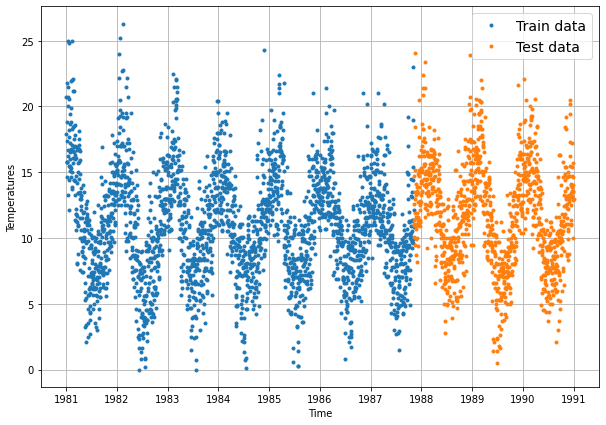

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=time_train, values=series_train, label="Train data")
plot_time_series(timesteps=time_val, values=series_val, label="Test data")

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, horizon=G.HORIZON, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
  ds = tf.data.Dataset.from_tensor_slices(series) # Tạo dữ liệu từ series
  ds = ds.window(window_size+horizon, shift=1, drop_remainder=True) # Cắt dataset vào các cửa sổ thích hợp
  ds = ds.flat_map(lambda w: w.batch(window_size+horizon)) # Làm phẳng các windows thành các lô
  ds = ds.shuffle(shuffle_buffer) # Xáo trộn dataset
  ds = ds.map(lambda window: (window[:-horizon], window[-horizon:])) # Tánh nó thành feature và labels
  ds = ds.batch(batch_size).prefetch(1) # Tạo các lô dữ liệu và thực hiện kỹ thuật tăng tốc
  return ds

train_dataset = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, horizon=G.HORIZON, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

# Model_0: Naive forecast

In [ ]:
naive_forecast = series_val[:-1]

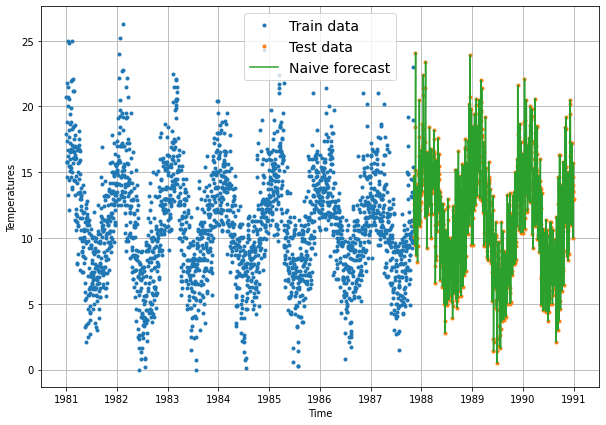

In [ ]:
# Vẽ biểu đồ naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=time_train, values=series_train, label="Train data")
plot_time_series(timesteps=time_val, values=series_val, label="Test data")
plot_time_series(timesteps=time_val[1:], values=naive_forecast, format="-", label="Naive forecast");

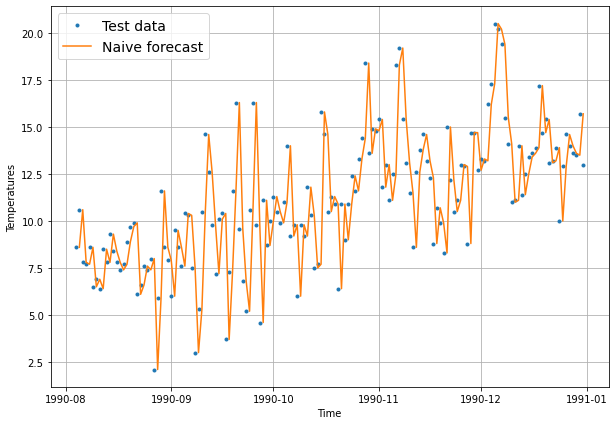

In [ ]:
plt.figure(figsize=(10, 7))
offset = 1000 # offset các giá trị 1000 bước thời gian
plot_time_series(timesteps=time_val, values=series_val, start=offset, label="Test data")
plot_time_series(timesteps=time_val[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [ ]:
naive_results = compute_metrics(true_series=series_val[1:],
                               forecast=naive_forecast)
naive_results

(6.682906875543952, 2.0120104438642294)

# Model_1: sử dụng kết hợp các layer Conv1D, LSTM và Dense

In [ ]:
model_1 = tf.keras.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu',
                             padding='causal', input_shape=[G.WINDOW_SIZE, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(G.HORIZON)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_1.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 64, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 68,725
Trainable params: 68,725
Non-traina

In [ ]:
history_lr = model_1.fit(train_dataset, epochs=50, callbacks=[lr_schedule])

Epoch 1/50
77/77 [==============================] - 5s 12ms/step - loss: 9.7222 - mae: 10.2210 - lr: 1.0000e-04
Epoch 2/50
77/77 [==============================] - 1s 12ms/step - loss: 7.6506 - mae: 8.1477 - lr: 1.1220e-04
Epoch 3/50
77/77 [==============================] - 1s 11ms/step - loss: 3.7167 - mae: 4.1906 - lr: 1.2589e-04
Epoch 4/50
77/77 [==============================] - 1s 12ms/step - loss: 2.4574 - mae: 2.9207 - lr: 1.4125e-04
Epoch 5/50
77/77 [==============================] - 1s 12ms/step - loss: 2.1302 - mae: 2.5873 - lr: 1.5849e-04
Epoch 6/50
77/77 [==============================] - 1s 12ms/step - loss: 1.8542 - mae: 2.3064 - lr: 1.7783e-04
Epoch 7/50
77/77 [==============================] - 1s 11ms/step - loss: 1.8183 - mae: 2.2706 - lr: 1.9953e-04
Epoch 8/50
77/77 [==============================] - 1s 12ms/step - loss: 1.8235 - mae: 2.2745 - lr: 2.2387e-04
Epoch 9/50
77/77 [==============================] - 1s 16ms/step - loss: 1.7363 - mae: 2.1870 - lr: 2.5119e-04


(0.0001, 10.0, 0.0, 10.0)

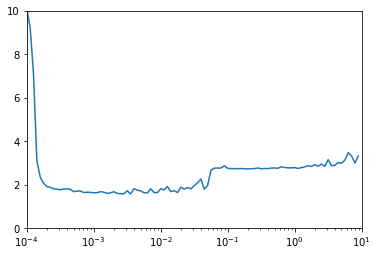

In [ ]:
plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
plt.axis([1e-4,10,0,10])

In [ ]:
model_1 = tf.keras.models.clone_model(model_1)
model_1.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                metrics=['mae'])
history_1 = model_1.fit(train_dataset, epochs=50)

Epoch 1/50
77/77 [==============================] - 15s 112ms/step - loss: 8.9973 - mae: 9.4941
Epoch 2/50
77/77 [==============================] - 9s 111ms/step - loss: 2.5039 - mae: 2.9659
Epoch 3/50
77/77 [==============================] - 15s 192ms/step - loss: 1.9195 - mae: 2.3739
Epoch 4/50
77/77 [==============================] - 11s 141ms/step - loss: 1.8345 - mae: 2.2841
Epoch 5/50
77/77 [==============================] - 9s 113ms/step - loss: 1.7542 - mae: 2.2036
Epoch 6/50
77/77 [==============================] - 15s 184ms/step - loss: 1.7564 - mae: 2.2109
Epoch 7/50
77/77 [==============================] - 11s 136ms/step - loss: 1.6920 - mae: 2.1402
Epoch 8/50
77/77 [==============================] - 14s 186ms/step - loss: 1.6416 - mae: 2.0879
Epoch 9/50
77/77 [==============================] - 8s 94ms/step - loss: 1.5843 - mae: 2.0286
Epoch 10/50
77/77 [==============================] - 10s 126ms/step - loss: 1.5631 - mae: 2.0061
Epoch 11/50
77/77 [========================

# Đánh giá các dự báo (trên tập dữ liệu đánh giá)

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
# Tính toán dự đoán cho tất cả series
model_0_forecast = model_forecast(model_1, G.SERIES, G.WINDOW_SIZE).squeeze()

# Cắt dự báo để chỉ nhận dự đoán cho bộ xác thực
model_0_forecast = model_0_forecast[G.SPLIT_TIME - G.WINDOW_SIZE: -1]

113/113 [==============================] - 6s 52ms/step


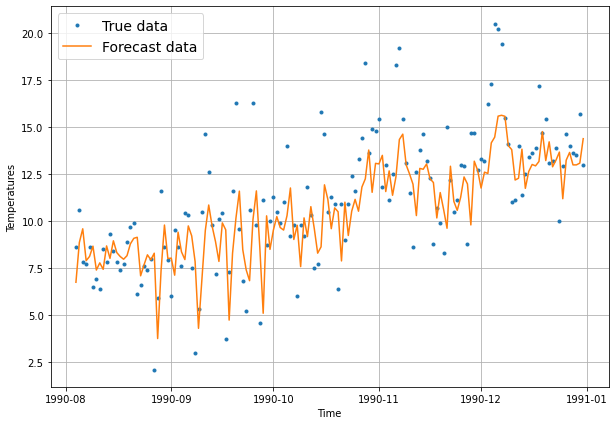

In [ ]:
offset = 1000
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=time_val, values=series_val, start=offset, label="True data")
plot_time_series(timesteps=time_val, values=model_0_forecast, start=offset, format="-", label="Forecast data");

In [ ]:
model_0_results = compute_metrics(true_series=series_val,
                                  forecast=model_0_forecast)
model_0_results

(5.5927978, 1.8408157)

# Model_2: Thuật toán N-BEATS

In [ ]:
HORIZON = 1 # dự đoán về tương lai
WINDOW_SIZE = 64 # xem xét quá khứ

In [ ]:
from keras.layers.convolutional.base_depthwise_conv import InputSpec
# Tạo layer NBeatsBlock tùy chỉnh
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, input_size: int, theta_size: int, horizon: int, 
               n_neurons: int, n_layers: int, 
               **kwargs): # đối số **kwargs quản lý tất cả các đối số cho parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon 
    self.n_neurons = n_neurons 
    self.n_layers = n_layers

    # Block chưa stack của 4 layers được kết nối đầy đủ, mỗi layer có kích hoạt là relu
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Đầu ra của block là theta layer với kích hoạt tuyến tính
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Xuất ra backcast và dự báo từ theta
    backcast, forecast = theta[:, self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

## Chuẩn bị dữ liệu cho thuật toán N-BEATS bằng tf.data

In [ ]:
import pandas as pd 
df = pd.read_csv(G.TEMPERATURES_CSV, parse_dates=['Date'], index_col=['Date'])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [ ]:
temp_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  temp_nbeats[f'Temp+{i+1}'] = temp_nbeats['Temp'].shift(periods=i+1)
temp_nbeats.dropna().head()

,Temp,Temp+1,Temp+2,Temp+3,Temp+4,Temp+5,Temp+6,Temp+7,Temp+8,Temp+9,...,Temp+55,Temp+56,Temp+57,Temp+58,Temp+59,Temp+60,Temp+61,Temp+62,Temp+63,Temp+64
Date,,,,,,,,,,,,,,,,,,,,,
1981-03-06,14.3,13.3,16.0,17.0,18.6,17.8,21.2,17.5,16.9,18.5,...,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
1981-03-07,11.4,14.3,13.3,16.0,17.0,18.6,17.8,21.2,17.5,16.9,...,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
1981-03-08,16.3,11.4,14.3,13.3,16.0,17.0,18.6,17.8,21.2,17.5,...,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
1981-03-09,16.1,16.3,11.4,14.3,13.3,16.0,17.0,18.6,17.8,21.2,...,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
1981-03-10,11.8,16.1,16.3,11.4,14.3,13.3,16.0,17.0,18.6,17.8,...,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8


In [ ]:
# Tạo các đặc trưng và nhãn
X = temp_nbeats.dropna().drop('Temp', axis=1)
y = temp_nbeats.dropna()['Temp']
split_size = int(len(X)*0.8)
# Tạo các tập huấn luyện và kiểm tra
X_train, y_train = X[:split_size], y[:split_size]
X_val, y_val = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_val), len(y_val)

(2868, 2868, 718, 718)

In [ ]:
# Biến mảng huấn luyện và kiểm tra thành tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

val_features_dataset = tf.data.Dataset.from_tensor_slices(X_val)
val_labels_dataset = tf.data.Dataset.from_tensor_slices(y_val)

# Kết hợp các đặc trưng & nhãn
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
val_dataset = tf.data.Dataset.zip((val_features_dataset, val_labels_dataset))

# Batch và prefetch cho chất lượng tối ưu
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
# Giá trị từ tài liệu N-BEATS: Hình 1 và Bảng 18/Phụ lục D
N_EPOCHS = 5000 # được gọi là "Iterations" trong Bảng 18
N_NEURONS = 512 # được gọi là "Width" trong Bảng 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # được gọi là "Lookback" trong Bảng 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(64, 65)

In [ ]:
%%time

tf.random.set_seed(42)
# 1. Thiết lập N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')
# 2. Tạo input cho các stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Tạo đầu vào backcast và forecast ban đầu
backcast, forecast = nbeats_block_layer(stack_input)
# Thêm liên kết subtraction residual
residuals = tf.keras.layers.subtract([stack_input, backcast], name='subtract_00')

# 4. Tạo các stack chứa block
for i, _ in enumerate(range(N_STACKS-1)): 
  # 5. Sử dụng NBeatsBlock để tính toán backcast cũng như block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f'NBeatsBlock_{i}')(residuals) # truyền nó trong residual (backcast)

      # 6. Tạo double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")
# 7. Kết hợp stack model với nhau
model_2 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_2_NBEATS')
model_2.compile(loss='huber',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])
history_2 = model_2.fit(train_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset,
                        verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 134: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 234: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 36s, sys: 1.95 s, total: 1min 38s
Wall time: 1min 53s


In [ ]:
model_2.evaluate(val_dataset)

1/1 [==============================] - 0s 115ms/step - loss: 1.3485 - mae: 1.7871 - mse: 5.1993


[1.348524808883667, 1.7870641946792603, 5.19930362701416]

In [ ]:
model_2_preds = make_preds(model_2, val_dataset)
model_2_preds[:10]

1/1 [==============================] - 0s 55ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([15.6579  , 13.926707, 14.440533, 16.249832, 17.828144, 16.736364,
       14.252497, 14.784973, 16.599386, 14.696848], dtype=float32)>

In [ ]:
model_2_results = compute_metrics(y_val,model_2_preds)
model_2_results

(5.1993036, 1.7870642)

In [ ]:
# model_2.save(model_2.name)